In [1]:
'''
# For GPU support, install the following packages:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install gymnasium[box2d]
'''

'\n# For GPU support, install the following packages:\n!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128\n!pip install gymnasium[box2d]\n'

In [26]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import gymnasium as gym
import itertools
import time
import matplotlib.pyplot as plt

In [27]:
# check if GPU is available
torch.cuda.is_available()

True

In [28]:
env = gym.make("LunarLanderContinuous-v3")

print("State shape:", env.observation_space.shape)
state_size = env.observation_space.shape[0]
print("State size:", state_size)
print("Number of continuous actions:", env.action_space.shape[0])

State shape: (8,)
State size: 8
Number of continuous actions: 2


In [29]:
main_bins = [-1, 1]
lateral_bins = [-1, 0, 1]

discrete_actions = np.array(list(itertools.product(main_bins, lateral_bins)))
number_actions = len(discrete_actions)

In [30]:
discrete_actions

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

In [31]:
learning_rate = 5e-4
minibatch_size = 64
discount_factor = 0.99
replay_buffer_size = int(1e5)
interpolation_parameter = 1e-3

In [32]:
class Network(nn.Module):
  def __init__(self, state_size, action_size, seed=42):
      super(Network, self).__init__()
      self.seed = torch.manual_seed(seed)
      self.fc1 = nn.Linear(state_size, 128)
      self.fc2 = nn.Linear(128, 128)
      self.fc3 = nn.Linear(128, 64)
      self.fc4 = nn.Linear(64, action_size)

  def forward(self, state):
      x = F.relu(self.fc1(state))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      return self.fc4(x)  # Output Q-values for each discrete action

In [33]:
class ReplayMemory(object):

  def __init__(self, capacity):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.capacity = capacity
    self.memory = []

  def push(self, event):
    self.memory.append(event)
    if len(self.memory) > self.capacity:
      del self.memory[0]

  def sample(self, batch_size):
    experiences = random.sample(self.memory, k = batch_size)
    states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
    actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
    rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
    next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
    dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
    return states, next_states, actions, rewards, dones

In [34]:
class Agent():

  def __init__(self, state_size, action_size):
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    self.state_size = state_size
    self.action_size = action_size
    self.discrete_actions = discrete_actions
    self.local_qnetwork = Network(state_size, action_size).to(self.device)
    self.target_qnetwork = Network(state_size, action_size).to(self.device)
    self.optimizer = optim.Adam(self.local_qnetwork.parameters(), lr = learning_rate)
    self.memory = ReplayMemory(replay_buffer_size)
    self.t_step = 0

  def step(self, state, action_idx, reward, next_state, done):
    self.memory.push((state, action_idx, reward, next_state, done))
    self.t_step = (self.t_step + 1) % 4
    if self.t_step == 0:
      if len(self.memory.memory) > minibatch_size:
        experiences = self.memory.sample(minibatch_size)
        self.learn(experiences, discount_factor)

  def act(self, state, epsilon = 0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
    self.local_qnetwork.eval()
    with torch.no_grad():
      q_values = self.local_qnetwork(state).cpu().data.numpy().squeeze()
    self.local_qnetwork.train()

    if np.random.rand() < epsilon:
        action_idx = np.random.randint(self.action_size)
    else:
        action_idx = np.argmax(q_values)
    return action_idx  # Return index


  def learn(self, experiences, discount_factor):
    states, next_states, actions, rewards, dones = experiences
    # For continuous actions, use MSE between predicted and taken actions (DDPG/A2C would be better)
    actions = actions.long()
    q_expected = self.local_qnetwork(states).gather(1, actions)
    q_targets_next = self.target_qnetwork(next_states).max(1)[0].unsqueeze(1)
    q_targets = rewards + discount_factor * q_targets_next * (1 - dones)
    loss = F.mse_loss(q_expected, q_targets)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
    self.soft_update(self.local_qnetwork, self.target_qnetwork, interpolation_parameter)

  def soft_update(self, local_model, target_model, interpolation_parameter):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(interpolation_parameter * local_param.data + (1.0 - interpolation_parameter) * target_param.data)

In [35]:
agent = Agent(state_size, number_actions)

In [12]:
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.996
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

# Store all episode rewards (not just the last 100)
episode_rewards = []

for episode in range(1, number_episodes + 1):
  state, _ = env.reset()
  score = 0
  for t in range(maximum_number_timesteps_per_episode):
    action_idx = agent.act(state, epsilon)
    action = discrete_actions[action_idx]
    next_state, reward, done, _, _ = env.step(action)

    agent.step(state, action_idx, reward, next_state, done)
    state = next_state
    score += reward
    if done:
      break
  scores_on_100_episodes.append(score)
  episode_rewards.append(score)  # Store the reward for this episode
  epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
  print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
  if episode % 100 == 0:
    print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(episode, np.mean(scores_on_100_episodes), epsilon))

  if np.mean(scores_on_100_episodes) >= 200.0:
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
    torch.save(agent.local_qnetwork.state_dict(), 'DQN_stage_1.pth')
    break


Episode 100	Average Score: -277.67	Epsilon: 0.67
Episode 200	Average Score: -110.08	Epsilon: 0.45
Episode 300	Average Score: -29.87	Epsilon: 0.30
Episode 400	Average Score: 88.22	Epsilon: 0.20
Episode 500	Average Score: 184.39	Epsilon: 0.13
Episode 525	Average Score: 201.02
Environment solved in 525 episodes!	Average Score: 201.02


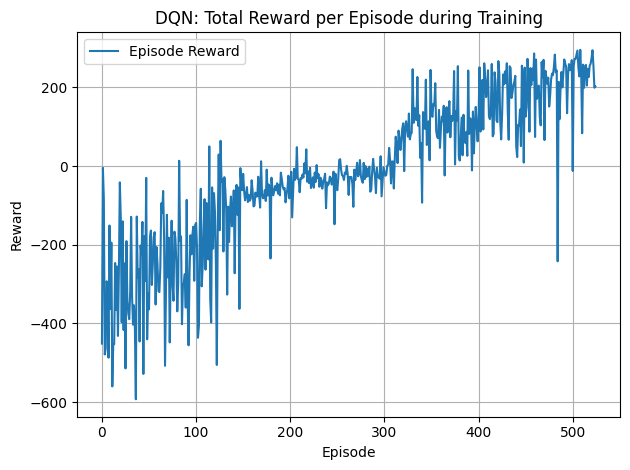

In [13]:
# Raw episode rewards
plt.plot(episode_rewards, label="Episode Reward")
plt.title("DQN: Total Reward per Episode during Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

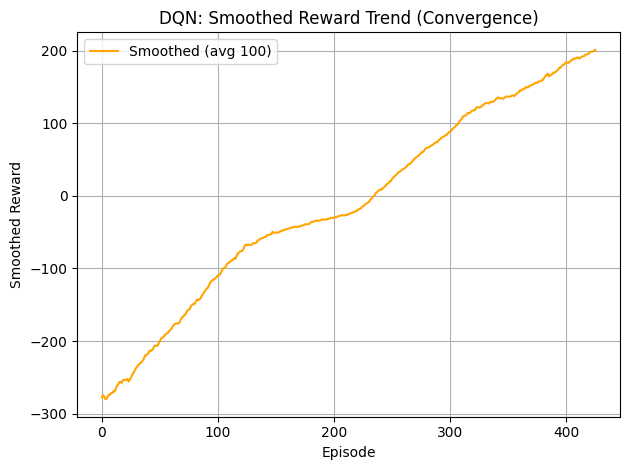

In [14]:
# Smoothed reward trend (moving average)
window = 100
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=f"Smoothed (avg {window})", color="orange")
    plt.title("DQN: Smoothed Reward Trend (Convergence)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
# Load the trained model weights
agent.local_qnetwork.load_state_dict(torch.load('DQN_stage_1.pth', weights_only=True))
agent.target_qnetwork.load_state_dict(torch.load('DQN_stage_1.pth', weights_only=True))

# Store all episode rewards (not just the last 100)
episode_rewards = []

# Now continue training as before
number_episodes = 2000
maximum_number_timesteps_per_episode = 1000
epsilon_starting_value  = 1.0
epsilon_ending_value  = 0.01
epsilon_decay_value  = 0.996
epsilon = epsilon_starting_value
scores_on_100_episodes = deque(maxlen = 100)

for episode in range(1, number_episodes + 1):
    state, _ = env.reset()
    score = 0
    for t in range(maximum_number_timesteps_per_episode):
        action_idx = agent.act(state, epsilon)
        action = discrete_actions[action_idx]
        next_state, reward, done, _, _ = env.step(action)


        distance_from_pad = abs(next_state[0])
        reward -= distance_from_pad * 2  # Penalize being far from the center

        reward -= 0.01  # Gentle time penalty


        agent.step(state, action_idx, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break
    scores_on_100_episodes.append(score)
    episode_rewards.append(score)  # Store the reward for this episode
    epsilon = max(epsilon_ending_value, epsilon_decay_value * epsilon)
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)), end = "")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(episode, np.mean(scores_on_100_episodes), epsilon))
    if np.mean(scores_on_100_episodes) >= 200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, np.mean(scores_on_100_episodes)))
        torch.save(agent.local_qnetwork.state_dict(), 'DQN_stage_2.pth')
        break

Episode 100	Average Score: -283.95	Epsilon: 0.67
Episode 200	Average Score: -251.10	Epsilon: 0.45
Episode 300	Average Score: -308.84	Epsilon: 0.30
Episode 400	Average Score: -106.42	Epsilon: 0.20
Episode 500	Average Score: 66.47	Epsilon: 0.13
Episode 599	Average Score: 200.33
Environment solved in 599 episodes!	Average Score: 200.33


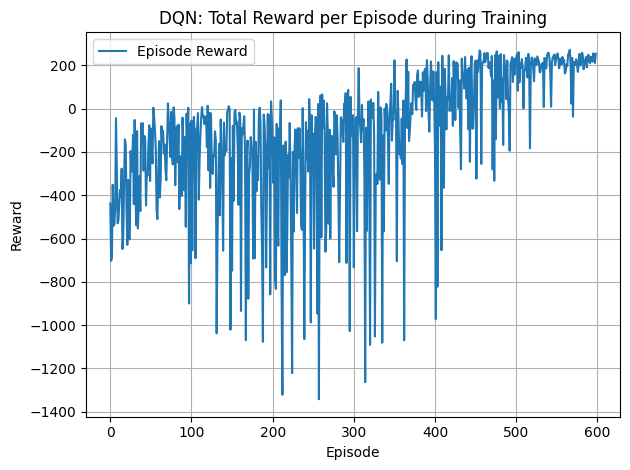

In [18]:
# Raw episode rewards
plt.plot(episode_rewards, label="Episode Reward")
plt.title("DQN: Total Reward per Episode during Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

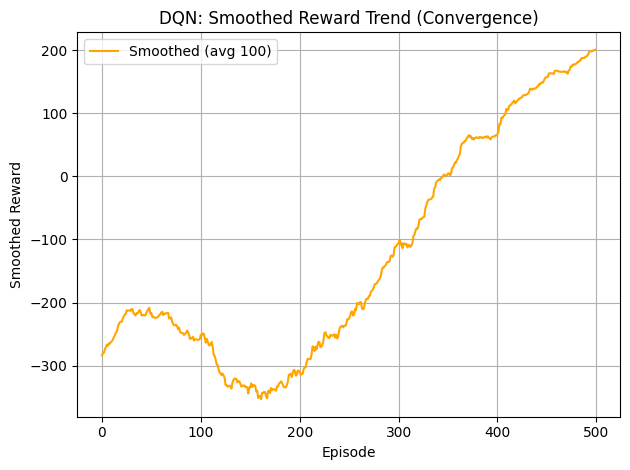

In [19]:
# Smoothed reward trend (moving average)
window = 100
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=f"Smoothed (avg {window})", color="orange")
    plt.title("DQN: Smoothed Reward Trend (Convergence)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
def play_with_pygame(agent, env_name, discrete_actions, delay=0.03):
    env = gym.make(env_name, render_mode="human", gravity=-10.0,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5)
    state, _ = env.reset()
    done = False
    while not done:
        action_idx = agent.act(state, epsilon=0.0)  # Greedy action
        action = discrete_actions[action_idx]
        state, reward, done, truncated, info = env.step(action)
        env.render()
        time.sleep(delay)
        if truncated:
            break
    env.close()

In [37]:
# Instantiate agent
agent = Agent(state_size, number_actions)

# Load the trained weights
agent.local_qnetwork.load_state_dict(torch.load('DQN_stage_2.pth', weights_only=True))
agent.target_qnetwork.load_state_dict(torch.load('DQN_stage_2.pth', weights_only=True))

<All keys matched successfully>

In [45]:
# Play using the trained agent
play_with_pygame(agent, "LunarLanderContinuous-v3", discrete_actions, delay=0.03)